# Двухслойная нейронная сеть для классификации
КБ-211 Коренев Денис

**Задание:** Построить двухслойную нейронную сеть для классификации на два класса. Разбивку на классы сделать по столбцу "правильных ответов". Если этот столбец непонятно как определить (можно спросить о нем у преподавателя), то использовать  разбиение на 2 кластера в задании 2 или 4. Классификацию проводить по всем признакам, а для визуализации использовать два наиболее значимых или главные компоненты из 4. (Вариант архитектуры сети - оба слоя полносвязных, первый слой с функцией активации Релу, а второй слой софтмакс или сигмоидная функция активации. Качество можно отслеживать с помощью точности, эпох должно быть не меньше 10; по поводу использования библиотек: предпочтительно написать не используя специальных библиотек для разработки нейронных сетей; если использовать всё-таки библиотеки, то лучше использовать тензорфло и керас в колабе; другие варианты - например, пайторч, тоже допустимы, но тогда обязательно оформление отчета). В выводе сравнить результаты с результатами из лабораторной 4.

**Архитектура сети:**
- Оба слоя полносвязные
- Первый слой с функцией активации ReLU
- Второй слой с сигмоидной функцией активации
- Минимум 10 эпох обучения

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import warnings
from concurrent.futures import ThreadPoolExecutor
import os

warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (12, 6)
sns.set_style('whitegrid')
pd.set_option('display.max_columns', None)

# Для воспроизводимости результатов
np.random.seed(42)

## 1. Загрузка и подготовка данных

Используем тот же датасет `maleorfemale.csv` и разметку из кластеризации задания 2/4.

In [76]:
df = pd.read_csv(r'data/02/maleorfemale.csv', nrows=100000)

print(f"Размер датасета: {df.shape}")
print("\nИнформация о данных:")
print(df.info())

label_column = None
for col in df.columns:
    if "cardio" in col.lower():
        label_column = col
        break

if label_column is None:
    obj_cols = df.select_dtypes(include=['object']).columns
    label_column = obj_cols[-1] if len(obj_cols) else None

print(f"\nСтолбец разметки: {label_column}")
labels = df[label_column]

# Признаки: все числовые, исключаем id и столбец разметки
exclude_cols = set([c for c in [label_column, 'id'] if c in df.columns])
feature_cols = [c for c in df.select_dtypes(
    include=[np.number]).columns if c not in exclude_cols]
X = df[feature_cols].values

print(f"Число признаков: {len(feature_cols)}")
print(f"Названия признаков: {feature_cols}")

Размер датасета: (70000, 13)

Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB
None

Столбец разметки: cardio
Число признаков: 11
Названия признаков: ['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 

## 2. Стандартизация и получение разметки

In [77]:
# Стандартизация признаков
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

y = labels.values

print(f"Разметка:")
print(f"Класс 0: {np.sum(y == 0)} объектов")
print(f"Класс 1: {np.sum(y == 1)} объектов")

Разметка:
Класс 0: 35021 объектов
Класс 1: 34979 объектов


## 3. Разделение на обучающую и тестовую выборки

In [78]:
# Разделяем данные на обучающую и тестовую выборки (70-30)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")
print(f"\nРаспределение классов в обучающей выборке:")
print(f"  Класс 0: {np.sum(y_train == 0)}")
print(f"  Класс 1: {np.sum(y_train == 1)}")
print(f"\nРаспределение классов в тестовой выборке:")
print(f"  Класс 0: {np.sum(y_test == 0)}")
print(f"  Класс 1: {np.sum(y_test == 1)}")
print(
    f"\nДисбаланс: Класс 0 в ~{np.sum(y_train == 0) / np.sum(y_train == 1):.1f} раз больше")

Размер обучающей выборки: (49000, 11)
Размер тестовой выборки: (21000, 11)

Распределение классов в обучающей выборке:
  Класс 0: 24515
  Класс 1: 24485

Распределение классов в тестовой выборке:
  Класс 0: 10506
  Класс 1: 10494

Дисбаланс: Класс 0 в ~1.0 раз больше


## 3.5. 04 работа на сердечных заболеваниях

Тут я взял переделал код из 04 работы под сердечные заболевания

### lr4.4. Реализация линейной дискриминантной функции Фишера

In [79]:
class FisherLDA:
    """
    Линейная дискриминантная функция Фишера для двух классов.
    """

    def __init__(self):
        self.w = None  # вектор весов (дискриминантные коэффициенты)
        self.w0 = None  # смещение (intercept)
        self.mean_0 = None  # среднее 1-го класса
        self.mean_1 = None  # среднее 2-го класса
        self.priors = None  # априорные вероятности классов

    def fit(self, X, y):
        """
        Обучение модели на данных.

        Алгоритм Фишера:
        1. Вычислить средние векторы m0 и m1 для каждого класса
        2. Вычислить матрицы рассеяния внутри класса S_w и между классами S_b
        3. Найти оптимальный вес w как: w = S_w^(-1) * (m1 - m0)
        4. Вычислить смещение w0
        """

        # Разделить данные по классам
        X_0 = X[y == 0]
        X_1 = X[y == 1]

        n_0 = X_0.shape[0]
        n_1 = X_1.shape[0]
        n_total = X.shape[0]

        # Вычислить средние векторы
        self.mean_0 = np.mean(X_0, axis=0)
        self.mean_1 = np.mean(X_1, axis=0)

        # Вычислить априорные вероятности
        self.priors = np.array([n_0 / n_total, n_1 / n_total])

        # Вычислить матрицы рассеяния внутри класса
        S_0 = np.cov(X_0.T)  # ковариационная матрица класса 0
        S_1 = np.cov(X_1.T)  # ковариационная матрица класса 1

        # Матрица рассеяния внутри класса (pooled covariance matrix)
        S_w = S_0 + S_1

        # Вычислить вектор весов w
        try:
            S_w_inv = np.linalg.inv(S_w)
            self.w = S_w_inv @ (self.mean_1 - self.mean_0)
        except np.linalg.LinAlgError:
            # Если матрица сингулярна, используем псевдообратную
            S_w_inv = np.linalg.pinv(S_w)
            self.w = S_w_inv @ (self.mean_1 - self.mean_0)

        # Вычислить смещение w0
        # w0 = -0.5 * w^T * (m0 + m1) + log(p1/p0)
        self.w0 = -0.5 * (self.mean_0 + self.mean_1) @ self.w + \
            np.log(self.priors[1] / self.priors[0])

        return self

    def decision_function(self, X):
        """
        Вычислить дискриминантную функцию.
        f(x) = w^T * x + w0
        """
        return X @ self.w + self.w0

    def predict(self, X):
        """
        Предсказать классы.
        Класс 0 если f(x) < 0, класс 1 если f(x) >= 0
        """
        return (self.decision_function(X) >= 0).astype(int)

    def predict_proba(self, X):
        """
        Вычислить вероятности принадлежности к классам.
        Используется сигмоидная функция для преобразования дискриминантной функции.
        """
        decision = self.decision_function(X)
        # Сигмоидная функция: 1 / (1 + exp(-x))
        proba_1 = 1.0 / (1.0 + np.exp(-decision))
        proba_0 = 1.0 - proba_1
        return np.column_stack([proba_0, proba_1])

#### Обучаем модель

In [80]:
print("Обучение модели Фишера...")
fisher = FisherLDA()
fisher.fit(X_train, y_train)

print("\nПараметры модели:")
print(
    f"Средний вектор класса 0: {fisher.mean_0[:5]} ... (показаны первые 5 признаков)")
print(
    f"Средний вектор класса 1: {fisher.mean_1[:5]} ... (показаны первые 5 признаков)")
print(f"Вектор весов w (первые 5): {fisher.w[:5]} ...")
print(f"Смещение w0: {fisher.w0:.6f}")
print(f"Норма вектора w: {np.linalg.norm(fisher.w):.6f}")

Обучение модели Фишера...

Параметры модели:
Средний вектор класса 0: [-0.24487992 -0.0069073   0.01300499 -0.17918772 -0.05236564] ... (показаны первые 5 признаков)
Средний вектор класса 1: [ 0.24266191  0.00571665 -0.01438494  0.18562885  0.05941055] ... (показаны первые 5 признаков)
Вектор весов w (первые 5): [ 0.2344137   0.02253013 -0.04545294  0.1768892   0.03913556] ...
Смещение w0: -0.001624
Норма вектора w: 0.370729


### lr4.5. Предсказание и оценка качества классификации

In [81]:
y_pred = fisher.predict(X_test)
y_pred_train = fisher.predict(X_train)

# Вычисляем метрики качества
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred)

precision_train = precision_score(y_train, y_pred_train)
precision_test = precision_score(y_test, y_pred)

recall_train = recall_score(y_train, y_pred_train)
recall_test = recall_score(y_test, y_pred)

f1_train = f1_score(y_train, y_pred_train)
f1_test = f1_score(y_test, y_pred)

# Матрица ошибок
cm_test = confusion_matrix(y_test, y_pred)
errors_test = y_pred != y_test

print("=" * 70)
print("ОЦЕНКА КАЧЕСТВА КЛАССИФИКАЦИИ")
print("=" * 70)

print("\nМетрики на обучающей выборке:")
print(f"  Accuracy:  {accuracy_train:.4f}")
print(f"  Precision: {precision_train:.4f}")
print(f"  Recall:    {recall_train:.4f}")
print(f"  F1-Score:  {f1_train:.4f}")

print("\nМетрики на тестовой выборке:")
print(f"  Accuracy:  {accuracy_test:.4f}")
print(f"  Precision: {precision_test:.4f}")
print(f"  Recall:    {recall_test:.4f}")
print(f"  F1-Score:  {f1_test:.4f}")

print("\nМатрица ошибок на тестовой выборке:")
print(cm_test)

print("\nДетальный отчет классификации на тестовой выборке:")
print(classification_report(y_test, y_pred, target_names=['Класс 0', 'Класс 1']))


ОЦЕНКА КАЧЕСТВА КЛАССИФИКАЦИИ

Метрики на обучающей выборке:
  Accuracy:  0.6498
  Precision: 0.6601
  Recall:    0.6169
  F1-Score:  0.6378

Метрики на тестовой выборке:
  Accuracy:  0.6410
  Precision: 0.6515
  Recall:    0.6052
  F1-Score:  0.6275

Матрица ошибок на тестовой выборке:
[[7109 3397]
 [4143 6351]]

Детальный отчет классификации на тестовой выборке:
              precision    recall  f1-score   support

     Класс 0       0.63      0.68      0.65     10506
     Класс 1       0.65      0.61      0.63     10494

    accuracy                           0.64     21000
   macro avg       0.64      0.64      0.64     21000
weighted avg       0.64      0.64      0.64     21000



### lr4.6. Анализ значимости признаков

Топ-10 наиболее значимых признаков (по абсолютному значению коэффициента):
  1. age                            :   0.234414
  2. cholesterol                    :   0.203370
  3. weight                         :   0.176889
  4. ap_lo                          :   0.056523
  5. height                         :  -0.045453
  6. ap_hi                          :   0.039136
  7. active                         :  -0.034779
  8. gluc                           :  -0.028840
  9. gender                         :   0.022530
  10. alco                           :  -0.016501


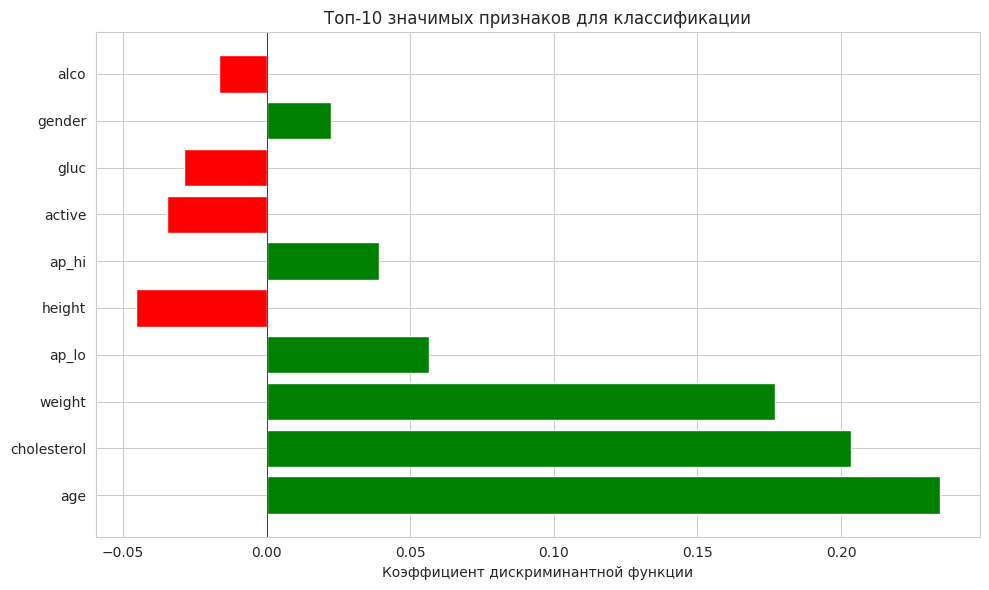

In [82]:
# Анализ значимости признаков по коэффициентам w
weights_abs = np.abs(fisher.w)
top_indices = np.argsort(weights_abs)[-10:][::-1]
top_features = [feature_cols[i] for i in top_indices]
top_weights = fisher.w[top_indices]

print("Топ-10 наиболее значимых признаков (по абсолютному значению коэффициента):")
for i, (feat, weight) in enumerate(zip(top_features, top_weights)):
    print(f"  {i+1}. {feat:30s} : {weight:10.6f}")

# Визуализация значимости признаков
fig, ax = plt.subplots(figsize=(10, 6))
y_pos = np.arange(len(top_features))
ax.barh(y_pos, top_weights, color=['green' if w > 0 else 'red' for w in top_weights])
ax.set_yticks(y_pos)
ax.set_yticklabels(top_features)
ax.set_xlabel('Коэффициент дискриминантной функции')
ax.set_title('Топ-10 значимых признаков для классификации')
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.show()

### lr4.7. Визуализация классификации в пространстве главных компонент (PCA)

Используем две главные компоненты для визуализации результатов классификации.

PCA - Объясненная дисперсия:
  PC1: 0.1899
  PC2: 0.1532
  Суммарно: 0.3431


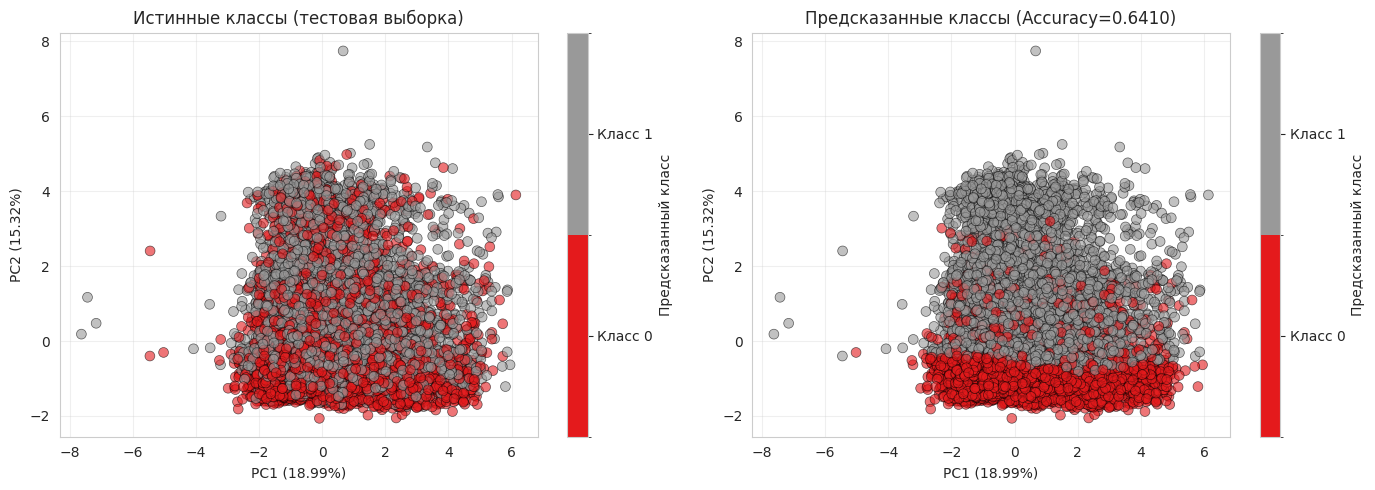

In [83]:
from matplotlib.colors import BoundaryNorm

# Применяем PCA для визуализации
pca = PCA(n_components=2, random_state=42)
X_test_pca = pca.fit_transform(X_test)
X_train_pca = pca.transform(X_train)

print(f"PCA - Объясненная дисперсия:")
print(f"  PC1: {pca.explained_variance_ratio_[0]:.4f}")
print(f"  PC2: {pca.explained_variance_ratio_[1]:.4f}")
print(f"  Суммарно: {pca.explained_variance_ratio_.sum():.4f}")

# Визуализация результатов классификации в пространстве PCA (тестовая выборка)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Истинные классы на тесте
scatter1 = axes[0].scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test, 
                           cmap='Set1', s=50, alpha=0.6, edgecolors='k', linewidth=0.5)
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
axes[0].set_title('Истинные классы (тестовая выборка)')
axes[0].grid(True, alpha=0.3)

cmap2 = plt.cm.get_cmap('Set1', 2)
norm = BoundaryNorm(boundaries=[-0.5, 0.5, 1.5], ncolors=2)
sm = plt.cm.ScalarMappable(cmap=cmap2, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=axes[0], ticks=[0, 1], boundaries=[-0.5, 0.5, 1.5])
cbar.set_label('Предсказанный класс')
cbar.ax.set_yticklabels(['Класс 0', 'Класс 1'])

# Предсказанные классы на тесте
scatter2 = axes[1].scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_pred, 
                           cmap='Set1', s=50, alpha=0.6, edgecolors='k', linewidth=0.5)
axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
axes[1].set_title(f'Предсказанные классы (Accuracy={accuracy_test:.4f})')
axes[1].grid(True, alpha=0.3)

cmap2 = plt.cm.get_cmap('Set1', 2)
norm = BoundaryNorm(boundaries=[-0.5, 0.5, 1.5], ncolors=2)
sm = plt.cm.ScalarMappable(cmap=cmap2, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=axes[1], ticks=[0, 1], boundaries=[-0.5, 0.5, 1.5])
cbar.set_label('Предсказанный класс')
cbar.ax.set_yticklabels(['Класс 0', 'Класс 1'])

plt.tight_layout()
plt.show()


### lr4.8. Визуализация граничной гиперплоскости в пространстве PCA

Визуализируем разделяющую гиперплоскость дискриминантной функции Фишера.

Вектор весов w в пространстве PCA: [0.06470898 0.66359523]


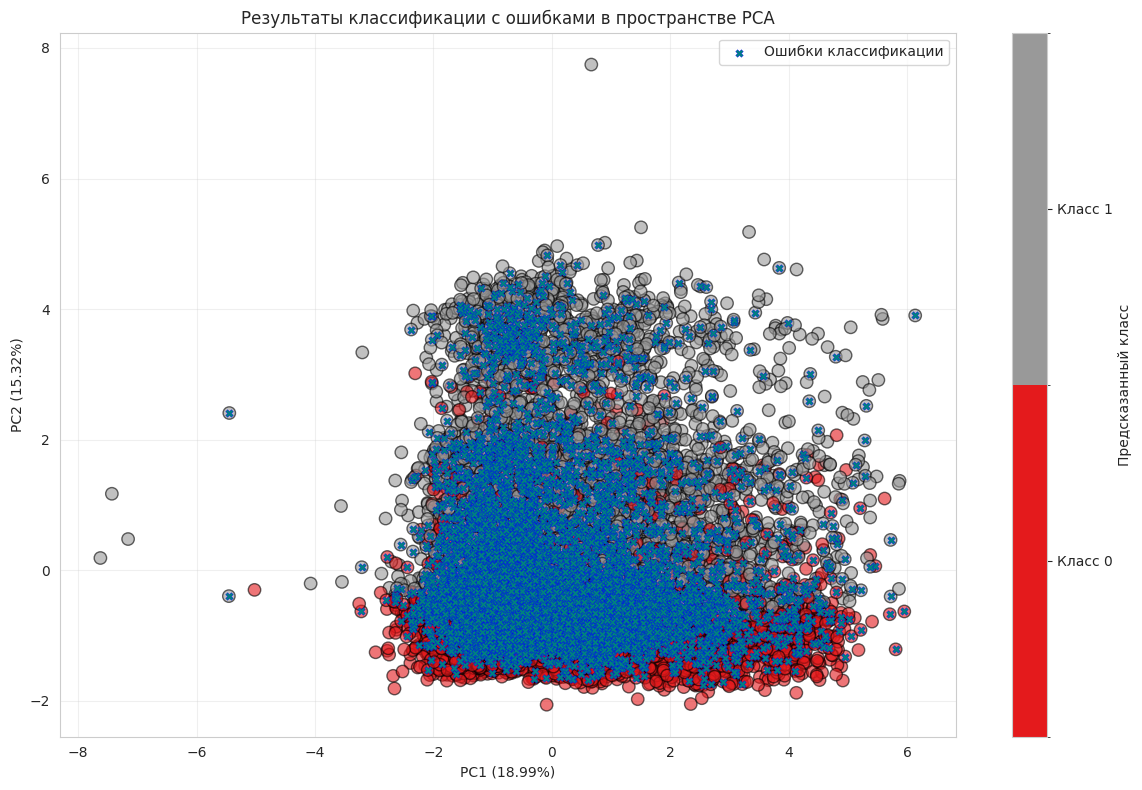


Количество ошибок: 7540 из 21000


In [84]:
from matplotlib.colors import BoundaryNorm

# Для визуализации разделяющей гиперплоскости нужно:
# 1. Спроецировать вектор весов w на пространство PCA
# 2. Построить сетку в пространстве PCA
# 3. Предсказать классы на сетке

# Проецируем весовой вектор в пространство PCA
# Сначала нормализуем w для наглядности
w_normalized = fisher.w / np.linalg.norm(fisher.w)
w_pca = pca.transform(w_normalized.reshape(1, -1))
print(f"Вектор весов w в пространстве PCA: {w_pca[0]}")

# Создаем сетку для визуализации
x_min, x_max = X_test_pca[:, 0].min() - 1, X_test_pca[:, 0].max() + 1
y_min, y_max = X_test_pca[:, 1].min() - 1, X_test_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                     np.linspace(y_min, y_max, 100))

# Обратное преобразование из PCA в исходное пространство для предсказания
X_mesh = np.c_[xx.ravel(), yy.ravel()]

fig, ax = plt.subplots(figsize=(12, 8))

scatter = ax.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_pred, 
                     cmap='Set1', s=80, alpha=0.6, edgecolors='k', linewidth=1)

# Отметим неправильные предсказания символом 'X'
errors = y_pred != y_test
if errors.sum() > 0:
    ax.scatter(X_test_pca[errors, 0], X_test_pca[errors, 1], 
               marker='X', s=30, c='teal', edgecolors='blue', linewidth=0.25, 
               label='Ошибки классификации')

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
ax.set_title('Результаты классификации с ошибками в пространстве PCA')

ax.grid(True, alpha=0.3)
cmap2 = plt.cm.get_cmap('Set1', 2)
norm = BoundaryNorm(boundaries=[-0.5, 0.5, 1.5], ncolors=2)
sm = plt.cm.ScalarMappable(cmap=cmap2, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, ticks=[0, 1], boundaries=[-0.5, 0.5, 1.5])
cbar.set_label('Предсказанный класс')
cbar.ax.set_yticklabels(['Класс 0', 'Класс 1'])

if errors.sum() > 0:
    ax.legend()
plt.tight_layout()
plt.show()

print(f"\nКоличество ошибок: {errors.sum()} из {len(y_test)}")


### lr4.9. Тепловая карта матрицы ошибок

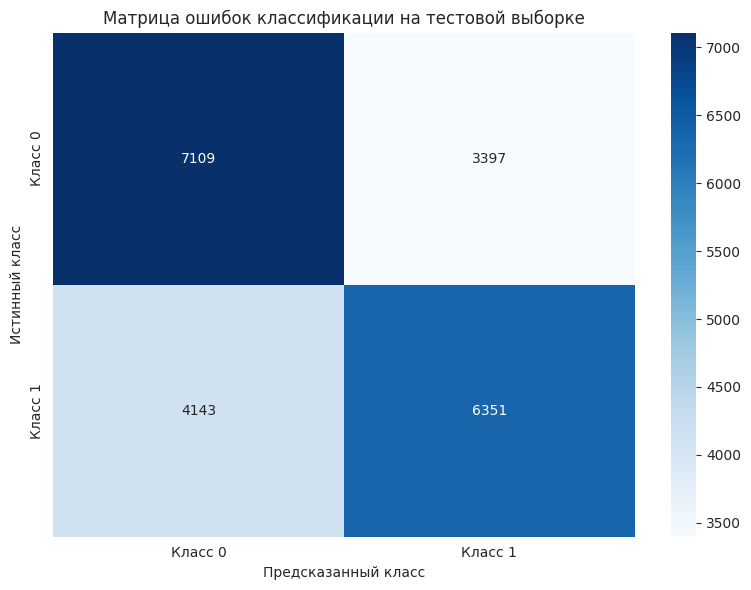


Дополнительные метрики из матрицы ошибок:
  True Negatives (TN):  7109
  False Positives (FP): 3397
  False Negatives (FN): 4143
  True Positives (TP):  6351
  Specificity:          0.6767
  Sensitivity:          0.6052


In [85]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', cbar=True, ax=ax,
            xticklabels=['Класс 0', 'Класс 1'],
            yticklabels=['Класс 0', 'Класс 1'])
ax.set_xlabel('Предсказанный класс')
ax.set_ylabel('Истинный класс')
ax.set_title('Матрица ошибок классификации на тестовой выборке')
plt.tight_layout()
plt.show()

# Из матрицы ошибок
tn, fp, fn, tp = cm_test.ravel()
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0

print(f"\nДополнительные метрики из матрицы ошибок:")
print(f"  True Negatives (TN):  {tn}")
print(f"  False Positives (FP): {fp}")
print(f"  False Negatives (FN): {fn}")
print(f"  True Positives (TP):  {tp}")
print(f"  Specificity:          {specificity:.4f}")
print(f"  Sensitivity:          {sensitivity:.4f}")

fisher_results = {
    'Метод': 'Fisher LDA (Лаб. 4)',
    'Accuracy': accuracy_test,
    'Precision': precision_test,
    'Recall': recall_test,
    'F1-Score': f1_test,
    'Specificity': specificity,
    'Sensitivity': sensitivity,
    'Errors': errors_test.sum(),
    'ErrorMatrix': cm_test
}


## 4. Реализация двухслойной нейронной сети

**Архитектура:**
- Входной слой: размерность = количество признаков
- Скрытый слой: функция активации ReLU
- Выходной слой: 1 нейрон, функция активации Sigmoid
- Функция потерь: Binary Cross-Entropy
- Оптимизатор: Градиентный спуск с momentum

In [ ]:
class TwoLayerNeuralNetwork:
    """
    Двухслойная нейронная сеть для бинарной классификации.

    Архитектура:
    - Слой 1: полносвязный + ReLU
    - Слой 2: полносвязный + Sigmoid
    
    Поддерживает параллельную обработку батчей с использованием всех доступных CPU.
    """

    def __init__(self, input_size, hidden_size, output_size=1, learning_rate=0.01, momentum=0.9, n_jobs=-1):
        """
        Инициализация параметров сети.

        Args:
            input_size: размерность входа
            hidden_size: количество нейронов в скрытом слое
            output_size: размерность выхода
            learning_rate: скорость обучения
            momentum: коэффициент момента
            n_jobs: количество потоков для параллельной обработки (-1 = все доступные CPU)
        """
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.n_jobs = os.cpu_count() if n_jobs == -1 else n_jobs

        # Инициализация весов (random)
        self.W1 = np.random.randn(
            input_size, hidden_size) * 0.01
        self.b1 = np.zeros((1, hidden_size))

        self.W2 = np.random.randn(
            hidden_size, output_size) * 0.01
        self.b2 = np.zeros((1, output_size))

        # Инициализация момента для оптимизации
        self.vW1 = np.zeros_like(self.W1)
        self.vb1 = np.zeros_like(self.b1)
        self.vW2 = np.zeros_like(self.W2)
        self.vb2 = np.zeros_like(self.b2)

        # История обучения
        self.loss_history = []
        self.accuracy_history = []

    def relu(self, Z):
        """ReLU функция активации."""
        return np.maximum(0, Z)

    def relu_derivative(self, Z):
        """Производная ReLU."""
        return (Z > 0).astype(float)

    def sigmoid(self, Z):
        """Сигмоидная функция активации."""
        # Для численной стабильности
        return 1 / (1 + np.exp(-np.clip(Z, -500, 500)))

    def sigmoid_derivative(self, A):
        """Производная сигмоиды."""
        return A * (1 - A)

    def forward(self, X):
        """
        Прямое распространение.

        Returns:
            A2: выход сети (вероятности)
            cache: промежуточные значения для обратного распространения
        """
        # Слой 1
        Z1 = X @ self.W1 + self.b1
        A1 = self.relu(Z1)

        # Слой 2
        Z2 = A1 @ self.W2 + self.b2
        A2 = self.sigmoid(Z2)

        cache = {
            'X': X,
            'Z1': Z1,
            'A1': A1,
            'Z2': Z2,
            'A2': A2
        }

        return A2, cache

    def compute_loss(self, y_true, y_pred):
        """
        Вычисление функции потерь (Binary Cross-Entropy).

        Args:
            y_true: истинные метки (m, 1)
            y_pred: предсказанные вероятности (m, 1)

        Returns:
            loss: значение функции потерь
        """
        m = y_true.shape[0]
        epsilon = 1e-15  # для численной стабильности
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)

        loss = -np.mean(y_true * np.log(y_pred) +
                        (1 - y_true) * np.log(1 - y_pred))
        return loss

    def backward(self, cache, y_true):
        """
        Обратное распространение ошибки.

        Args:
            cache: промежуточные значения из прямого прохода
            y_true: истинные метки (m, 1)

        Returns:
            gradients: градиенты для всех параметров
        """
        m = y_true.shape[0]
        X = cache['X']
        A1 = cache['A1']
        A2 = cache['A2']
        Z1 = cache['Z1']

        # Градиент выходного слоя
        dZ2 = A2 - y_true  # производная Binary Cross-Entropy + Sigmoid
        dW2 = (A1.T @ dZ2) / m
        db2 = np.sum(dZ2, axis=0, keepdims=True) / m

        # Градиент скрытого слоя
        dA1 = dZ2 @ self.W2.T
        dZ1 = dA1 * self.relu_derivative(Z1)
        dW1 = (X.T @ dZ1) / m
        db1 = np.sum(dZ1, axis=0, keepdims=True) / m

        gradients = {
            'dW1': dW1,
            'db1': db1,
            'dW2': dW2,
            'db2': db2
        }

        return gradients

    def update_parameters(self, gradients):
        """
        Обновление параметров с использованием градиентного спуска с momentum.

        Args:
            gradients: градиенты параметров
        """
        # Обновление момента
        self.vW1 = self.momentum * self.vW1 - \
            self.learning_rate * gradients['dW1']
        self.vb1 = self.momentum * self.vb1 - \
            self.learning_rate * gradients['db1']
        self.vW2 = self.momentum * self.vW2 - \
            self.learning_rate * gradients['dW2']
        self.vb2 = self.momentum * self.vb2 - \
            self.learning_rate * gradients['db2']

        # Обновление параметров
        self.W1 += self.vW1
        self.b1 += self.vb1
        self.W2 += self.vW2
        self.b2 += self.vb2

    def _process_single_batch(self, X_batch, y_batch):
        """
        Обработка одного батча (для параллелизации).
        
        Args:
            X_batch: данные батча
            y_batch: метки батча
            
        Returns:
            tuple: (loss, gradients)
        """
        # Прямое распространение
        Z1 = X_batch @ self.W1 + self.b1
        A1 = np.maximum(0, Z1)  # ReLU
        Z2 = A1 @ self.W2 + self.b2
        A2 = 1 / (1 + np.exp(-np.clip(Z2, -500, 500)))  # Sigmoid
        
        # Вычисление функции потерь
        m = y_batch.shape[0]
        epsilon = 1e-15
        y_pred = np.clip(A2, epsilon, 1 - epsilon)
        loss = -np.mean(y_batch * np.log(y_pred) + (1 - y_batch) * np.log(1 - y_pred))
        
        # Обратное распространение
        dZ2 = A2 - y_batch
        dW2 = (A1.T @ dZ2) / m
        db2 = np.sum(dZ2, axis=0, keepdims=True) / m
        
        dA1 = dZ2 @ self.W2.T
        dZ1 = dA1 * (Z1 > 0).astype(float)  # ReLU derivative
        dW1 = (X_batch.T @ dZ1) / m
        db1 = np.sum(dZ1, axis=0, keepdims=True) / m
        
        gradients = {
            'dW1': dW1,
            'db1': db1,
            'dW2': dW2,
            'db2': db2
        }
        
        return loss, gradients

    def fit(self, X_train, y_train, X_val=None, y_val=None, epochs=10, batch_size=256, verbose=True):
        """
        Обучение нейронной сети. Использует крупные батчи для эффективного использования
        многопоточности NumPy.

        Args:
            X_train: обучающие данные (m, n_features)
            y_train: обучающие метки (m,)
            X_val: валидационные данные
            y_val: валидационные метки
            epochs: количество эпох
            batch_size: размер мини-батча (по умолчанию 256 для эффективного использования ядер)
            verbose: печатать информацию о процессе обучения
        """
        m = X_train.shape[0]
        y_train = y_train.reshape(-1, 1)

        if y_val is not None:
            y_val = y_val.reshape(-1, 1)

        if verbose:
            print(f"Оптимизированная обработка: batch_size={batch_size} (NumPy использует {self.n_jobs} ядер внутренне)")

        for epoch in range(epochs):
            # Перемешиваем данные
            indices = np.random.permutation(m)
            X_shuffled = X_train[indices]
            y_shuffled = y_train[indices]

            # Последовательная обработка батчей (NumPy автоматически использует все ядра)
            epoch_losses = []
            all_gradients = {'dW1': [], 'db1': [], 'dW2': [], 'db2': []}
            
            for i in range(0, m, batch_size):
                X_batch = X_shuffled[i:i+batch_size]
                y_batch = y_shuffled[i:i+batch_size]
                
                loss, gradients = self._process_single_batch(X_batch, y_batch)
                epoch_losses.append(loss)
                
                for key in all_gradients:
                    all_gradients[key].append(gradients[key])
            
            # Усреднение градиентов
            avg_gradients = {
                key: np.mean(all_gradients[key], axis=0) 
                for key in all_gradients
            }

            # Обновление параметров
            self.update_parameters(avg_gradients)

            # Средняя потеря за эпоху
            avg_loss = np.mean(epoch_losses)
            self.loss_history.append(avg_loss)

            # Вычисление точности на обучающей выборке
            y_pred_train, _ = self.forward(X_train)
            y_pred_train_class = (y_pred_train >= 0.5).astype(int)
            train_accuracy = np.mean(y_pred_train_class == y_train)
            self.accuracy_history.append(train_accuracy)

            # Вывод информации
            if verbose and (epoch + 1) % 5 == 0:
                if X_val is not None and y_val is not None:
                    y_pred_val, _ = self.forward(X_val)
                    val_loss = self.compute_loss(y_val, y_pred_val)
                    y_pred_val_class = (y_pred_val >= 0.5).astype(int)
                    val_accuracy = np.mean(y_pred_val_class == y_val)
                    print(f"Эпоха {epoch+1}/{epochs} - "
                          f"Loss: {avg_loss:.4f}, Acc: {train_accuracy:.4f}, "
                          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")
                else:
                    print(f"Эпоха {epoch+1}/{epochs} - "
                          f"Loss: {avg_loss:.4f}, Accuracy: {train_accuracy:.4f}")

    def predict_proba(self, X):
        """
        Предсказание вероятностей.

        Args:
            X: входные данные (m, n_features)

        Returns:
            probabilities: вероятности класса 1
        """
        y_pred, _ = self.forward(X)
        return y_pred

    def predict(self, X, threshold=0.5):
        """
        Предсказание классов.

        Args:
            X: входные данные (m, n_features)
            threshold: порог для классификации

        Returns:
            predictions: предсказанные классы (0 или 1)
        """
        y_pred = self.predict_proba(X)
        return (y_pred >= threshold).astype(int).flatten()

## 5. Обучение нейронной сети

Создаем и обучаем модель на обучающей выборке. Используем тестовую выборку для валидации.

In [87]:
# Параметры модели
input_size = X_train.shape[1]
hidden_size = 33
learning_rate = 0.05
momentum = 0.9
epochs = 500

In [88]:
print(f"Создание нейронной сети:")
print(f"  Размер входного слоя: {input_size}")
print(f"  Размер скрытого слоя: {hidden_size}")
print(f"  Размер выходного слоя: 1 (бинарная классификация)")
print(f"  Скорость обучения: {learning_rate}")
print(f"  Momentum: {momentum}")

nn = TwoLayerNeuralNetwork(
    input_size=input_size,
    hidden_size=hidden_size,
    output_size=1,
    learning_rate=learning_rate,
    momentum=momentum
)

print("\nНачало обучения...")
print("=" * 70)
nn.fit(
    X_train, y_train,
    X_val=X_test, y_val=y_test,
    epochs=epochs,
    verbose=True
)
print("=" * 70)
print("Обучение завершено")


y_pred_train = nn.predict(X_train)
y_pred_test = nn.predict(X_test)

accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)

precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test)

Создание нейронной сети:
  Размер входного слоя: 11
  Размер скрытого слоя: 33
  Размер выходного слоя: 1 (бинарная классификация)
  Скорость обучения: 0.05
  Momentum: 0.9

Начало обучения...
Оптимизированная обработка: batch_size=256 (NumPy использует 12 ядер внутренне)
Эпоха 5/500 - Loss: 0.6931, Acc: 0.5313, Val Loss: 0.6931, Val Acc: 0.5319
Эпоха 10/500 - Loss: 0.6930, Acc: 0.5881, Val Loss: 0.6930, Val Acc: 0.5870
Эпоха 15/500 - Loss: 0.6928, Acc: 0.5930, Val Loss: 0.6928, Val Acc: 0.5913
Эпоха 20/500 - Loss: 0.6926, Acc: 0.5978, Val Loss: 0.6926, Val Acc: 0.5947
Эпоха 25/500 - Loss: 0.6923, Acc: 0.6047, Val Loss: 0.6923, Val Acc: 0.6019
Эпоха 30/500 - Loss: 0.6919, Acc: 0.6127, Val Loss: 0.6918, Val Acc: 0.6120
Эпоха 35/500 - Loss: 0.6912, Acc: 0.6198, Val Loss: 0.6912, Val Acc: 0.6187
Эпоха 40/500 - Loss: 0.6903, Acc: 0.6270, Val Loss: 0.6902, Val Acc: 0.6255
Эпоха 45/500 - Loss: 0.6888, Acc: 0.6319, Val Loss: 0.6887, Val Acc: 0.6298
Эпоха 50/500 - Loss: 0.6867, Acc: 0.6360, Va

#### Реализация с использованием Keras для проверки на адекватность модели

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers, models
import tensorflow as tf

# Создание модели Keras
keras_model = models.Sequential([
    layers.Dense(hidden_size, activation='relu', input_shape=(input_size,)),
    layers.Dense(1, activation='sigmoid')
])

# Компиляция модели
keras_model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    print(f"Используется HW ACC: {physical_devices[0]}")
else:
    print("HW ACC не обнаружен, используется CPU.")

print("Архитектура Keras модели:")
keras_model.summary()

# Обучение модели
print("\nНачало обучения Keras модели...")
print("=" * 70)

history = keras_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=epochs,
    batch_size=256,
    verbose=2,
    steps_per_epoch=20
)

print("=" * 70)
print("Обучение Keras модели завершено")

# Предсказания
y_pred_keras_train = (keras_model.predict(X_train) >= 0.5).astype(int).flatten()
y_pred_keras_test = (keras_model.predict(X_test) >= 0.5).astype(int).flatten()

# Метрики
accuracy_keras_train = accuracy_score(y_train, y_pred_keras_train)
accuracy_keras_test = accuracy_score(y_test, y_pred_keras_test)

precision_keras_test = precision_score(y_test, y_pred_keras_test)
recall_keras_test = recall_score(y_test, y_pred_keras_test)
f1_keras_test = f1_score(y_test, y_pred_keras_test)

cm_keras_test = confusion_matrix(y_test, y_pred_keras_test)

print("\n" + "=" * 70)
print("РЕЗУЛЬТАТЫ KERAS МОДЕЛИ")
print("=" * 70)
print(f"\nТочность на обучающей выборке: {accuracy_keras_train:.4f}")
print(f"Точность на тестовой выборке:  {accuracy_keras_test:.4f}")
print(f"\nМетрики на тестовой выборке:")
print(f"  Accuracy:  {accuracy_keras_test:.4f}")
print(f"  Precision: {precision_keras_test:.4f}")
print(f"  Recall:    {recall_keras_test:.4f}")
print(f"  F1-Score:  {f1_keras_test:.4f}")
print(f"\nМатрица ошибок:")
print(cm_keras_test)



HW ACC не обнаружен, используется CPU.
Архитектура Keras модели:


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 33)             │           396 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 430 (1.68 KB)

 Trainable params: 430 (1.68 KB)

 Non-trainable params: 0 (0.00 B)


Начало обучения Keras модели...
Epoch 1/500
20/20 - 2s - 100ms/step - accuracy: 0.5826 - loss: 0.6706 - val_accuracy: 0.6300 - val_loss: 0.6412
Epoch 2/500
20/20 - 0s - 23ms/step - accuracy: 0.6463 - loss: 0.6307 - val_accuracy: 0.6397 - val_loss: 0.6345
Epoch 3/500
20/20 - 0s - 25ms/step - accuracy: 0.6621 - loss: 0.6188 - val_accuracy: 0.6425 - val_loss: 0.6317
Epoch 4/500
20/20 - 0s - 22ms/step - accuracy: 0.6449 - loss: 0.6394 - val_accuracy: 0.6479 - val_loss: 0.6284
Epoch 5/500
20/20 - 1s - 26ms/step - accuracy: 0.6590 - loss: 0.6242 - val_accuracy: 0.6479 - val_loss: 0.6272
Epoch 6/500
20/20 - 1s - 27ms/step - accuracy: 0.6631 - loss: 0.6201 - val_accuracy: 0.6504 - val_loss: 0.6260
Epoch 7/500
20/20 - 0s - 22ms/step - accuracy: 0.6590 - loss: 0.6142 - val_accuracy: 0.6513 - val_loss: 0.6236
Epoch 8/500
20/20 - 0s - 23ms/step - accuracy: 0.6633 - loss: 0.6196 - val_accuracy: 0.6587 - val_loss: 0.6196
Epoch 9/500
20/20 - 0s - 21ms/step - accuracy: 0.6600 - loss: 0.6131 - val_acc

In [90]:
# Сравнение с моей реализацией
print("\n" + "=" * 70)
print("СРАВНЕНИЕ: Моя реализация vs Keras")
print("=" * 70)
print(f"{'Метрика':<20} {'Моя реализация':<20} {'Keras':<20} {'Разница':<15}")
print("=" * 70)
print(f"{'Accuracy (train)':<20} {accuracy_train:.4f}{'':<15} {accuracy_keras_train:.4f}{'':<15} {(accuracy_keras_train-accuracy_train)*100:+.2f}%")
print(f"{'Accuracy (test)':<20} {accuracy_test:.4f}{'':<15} {accuracy_keras_test:.4f}{'':<15} {(accuracy_keras_test-accuracy_test)*100:+.2f}%")
print(f"{'Precision (test)':<20} {precision_test:.4f}{'':<15} {precision_keras_test:.4f}{'':<15} {(precision_keras_test-precision_test)*100:+.2f}%")
print(f"{'Recall (test)':<20} {recall_test:.4f}{'':<15} {recall_keras_test:.4f}{'':<15} {(recall_keras_test-recall_test)*100:+.2f}%")
print(f"{'F1-Score (test)':<20} {f1_test:.4f}{'':<15} {f1_keras_test:.4f}{'':<15} {(f1_keras_test-f1_test)*100:+.2f}%")
print("=" * 70)


СРАВНЕНИЕ: Моя реализация vs Keras
Метрика              Моя реализация       Keras                Разница        
Accuracy (train)     0.7268                0.7318                +0.51%
Accuracy (test)      0.7200                0.7244                +0.44%
Precision (test)     0.7345                0.7374                +0.29%
Recall (test)        0.6884                0.6965                +0.81%
F1-Score (test)      0.7107                0.7164                +0.56%


## 6. Визуализация процесса обучения

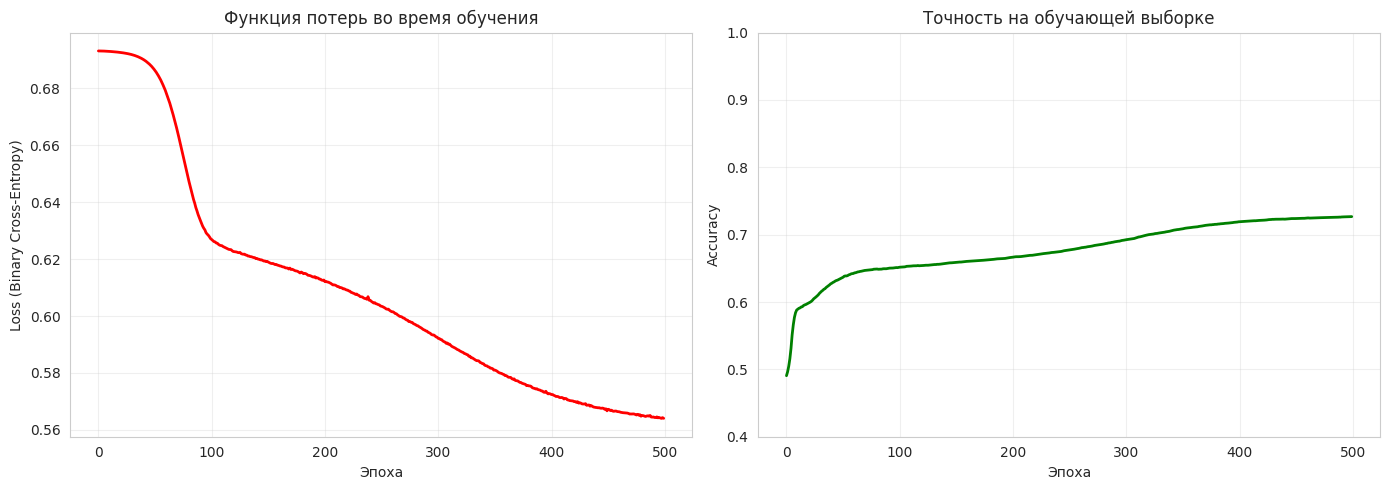

Начальная потеря: 0.6931
Конечная потеря: 0.5641
Начальная точность: 0.4906
Конечная точность: 0.7268


In [91]:
# Визуализация функции потерь и точности во время обучения
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# График функции потерь
axes[0].plot(nn.loss_history, linewidth=2, color='red')
axes[0].set_xlabel('Эпоха')
axes[0].set_ylabel('Loss (Binary Cross-Entropy)')
axes[0].set_title('Функция потерь во время обучения')
axes[0].grid(True, alpha=0.3)

# График точности
axes[1].plot(nn.accuracy_history, linewidth=2, color='green')
axes[1].set_xlabel('Эпоха')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Точность на обучающей выборке')
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim([0.4, 1.0])

plt.tight_layout()
plt.show()

print(f"Начальная потеря: {nn.loss_history[0]:.4f}")
print(f"Конечная потеря: {nn.loss_history[-1]:.4f}")
print(f"Начальная точность: {nn.accuracy_history[0]:.4f}")
print(f"Конечная точность: {nn.accuracy_history[-1]:.4f}")

## 7. Оценка качества классификации

In [92]:
# Предсказания на обучающей и тестовой выборках
y_pred_train = nn.predict(X_train)
y_pred_test = nn.predict(X_test)

# Вычисляем метрики качества
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)

precision_train = precision_score(y_train, y_pred_train)
precision_test = precision_score(y_test, y_pred_test)

recall_train = recall_score(y_train, y_pred_train)
recall_test = recall_score(y_test, y_pred_test)

f1_train = f1_score(y_train, y_pred_train)
f1_test = f1_score(y_test, y_pred_test)

# Матрица ошибок
cm_train = confusion_matrix(y_train, y_pred_train)
cm_test = confusion_matrix(y_test, y_pred_test)

print("=" * 70)
print("ОЦЕНКА КАЧЕСТВА КЛАССИФИКАЦИИ НЕЙРОННОЙ СЕТИ")
print("=" * 70)

print("\nМетрики на обучающей выборке:")
print(f"  Accuracy:  {accuracy_train:.4f}")
print(f"  Precision: {precision_train:.4f}")
print(f"  Recall:    {recall_train:.4f}")
print(f"  F1-Score:  {f1_train:.4f}")

print("\nМетрики на тестовой выборке:")
print(f"  Accuracy:  {accuracy_test:.4f}")
print(f"  Precision: {precision_test:.4f}")
print(f"  Recall:    {recall_test:.4f}")
print(f"  F1-Score:  {f1_test:.4f}")

print("\nМатрица ошибок на тестовой выборке:")
print(cm_test)

print("\nДетальный отчет классификации на тестовой выборке:")
print(classification_report(y_test, y_pred_test,
      target_names=['Класс 0', 'Класс 1']))

ОЦЕНКА КАЧЕСТВА КЛАССИФИКАЦИИ НЕЙРОННОЙ СЕТИ

Метрики на обучающей выборке:
  Accuracy:  0.7268
  Precision: 0.7423
  Recall:    0.6942
  F1-Score:  0.7175

Метрики на тестовой выборке:
  Accuracy:  0.7200
  Precision: 0.7345
  Recall:    0.6884
  F1-Score:  0.7107

Матрица ошибок на тестовой выборке:
[[7895 2611]
 [3270 7224]]

Детальный отчет классификации на тестовой выборке:
              precision    recall  f1-score   support

     Класс 0       0.71      0.75      0.73     10506
     Класс 1       0.73      0.69      0.71     10494

    accuracy                           0.72     21000
   macro avg       0.72      0.72      0.72     21000
weighted avg       0.72      0.72      0.72     21000



## 8. Тепловая карта матрицы ошибок

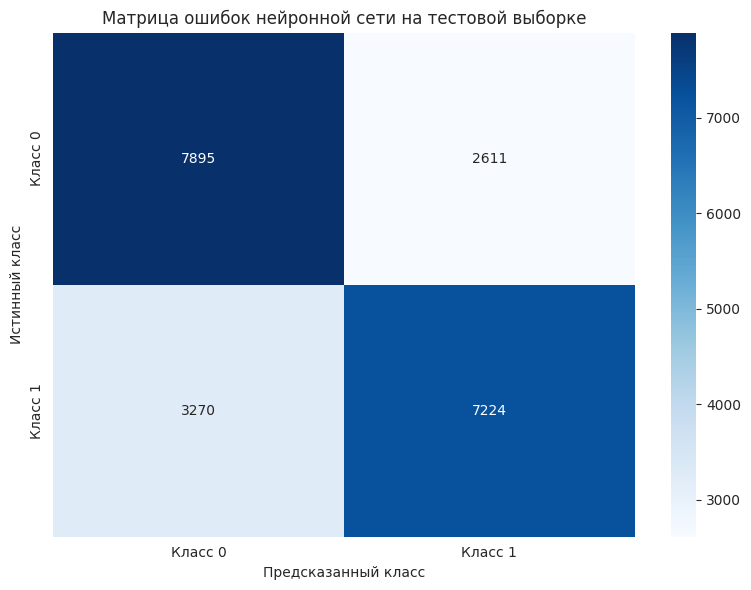


Дополнительные метрики из матрицы ошибок:
  True Negatives (TN):  7895
  False Positives (FP): 2611
  False Negatives (FN): 3270
  True Positives (TP):  7224
  Specificity:          0.7515
  Sensitivity:          0.6884


In [93]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', cbar=True, ax=ax,
            xticklabels=['Класс 0', 'Класс 1'],
            yticklabels=['Класс 0', 'Класс 1'])
ax.set_xlabel('Предсказанный класс')
ax.set_ylabel('Истинный класс')
ax.set_title('Матрица ошибок нейронной сети на тестовой выборке')
plt.tight_layout()
plt.show()

# Дополнительные метрики из матрицы ошибок
tn, fp, fn, tp = cm_test.ravel()
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0

print(f"\nДополнительные метрики из матрицы ошибок:")
print(f"  True Negatives (TN):  {tn}")
print(f"  False Positives (FP): {fp}")
print(f"  False Negatives (FN): {fn}")
print(f"  True Positives (TP):  {tp}")
print(f"  Specificity:          {specificity:.4f}")
print(f"  Sensitivity:          {sensitivity:.4f}")

## 9. Визуализация результатов в пространстве PCA

Используем PCA для визуализации результатов классификации в двумерном пространстве.

PCA - Объясненная дисперсия:
  PC1: 0.1899
  PC2: 0.1532
  Суммарно: 0.3431


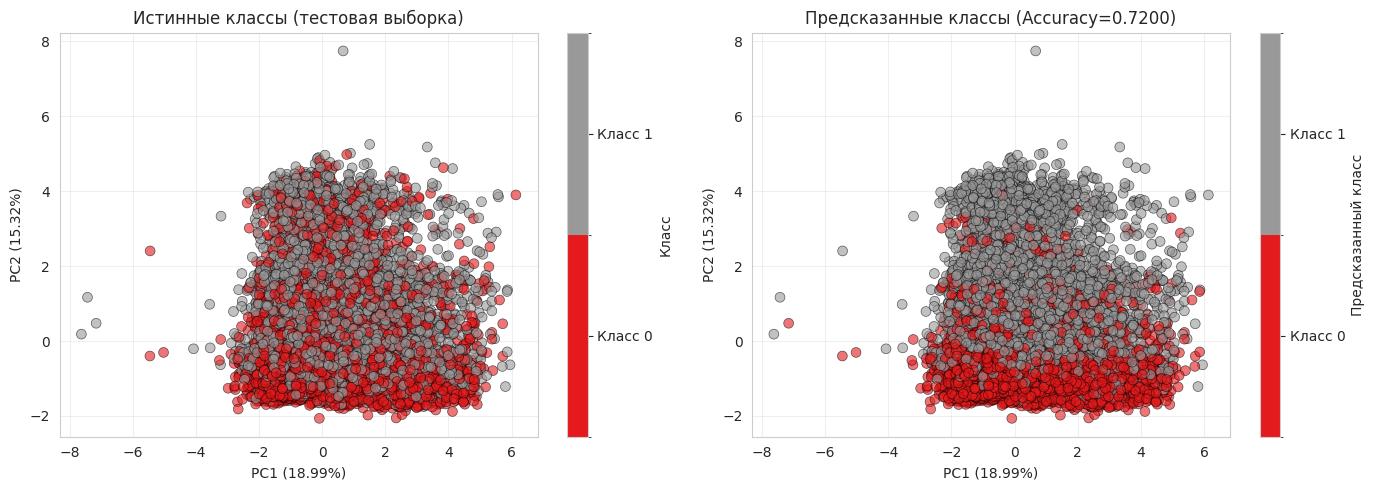

In [94]:
from matplotlib.colors import BoundaryNorm

# Применяем PCA для визуализации
pca = PCA(n_components=2, random_state=42)
X_test_pca = pca.fit_transform(X_test)
X_train_pca = pca.transform(X_train)

print(f"PCA - Объясненная дисперсия:")
print(f"  PC1: {pca.explained_variance_ratio_[0]:.4f}")
print(f"  PC2: {pca.explained_variance_ratio_[1]:.4f}")
print(f"  Суммарно: {pca.explained_variance_ratio_.sum():.4f}")

# Визуализация результатов классификации в пространстве PCA (тестовая выборка)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Истинные классы на тесте
scatter1 = axes[0].scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test,
                           cmap='Set1', s=50, alpha=0.6, edgecolors='k', linewidth=0.5)
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
axes[0].set_title('Истинные классы (тестовая выборка)')
axes[0].grid(True, alpha=0.3)

cmap2 = plt.cm.get_cmap('Set1', 2)
norm = BoundaryNorm(boundaries=[-0.5, 0.5, 1.5], ncolors=2)
sm = plt.cm.ScalarMappable(cmap=cmap2, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=axes[0], ticks=[0, 1], boundaries=[-0.5, 0.5, 1.5])
cbar.set_label('Класс')
cbar.ax.set_yticklabels(['Класс 0', 'Класс 1'])

# Предсказанные классы на тесте
scatter2 = axes[1].scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_pred_test,
                           cmap='Set1', s=50, alpha=0.6, edgecolors='k', linewidth=0.5)
axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
axes[1].set_title(f'Предсказанные классы (Accuracy={accuracy_test:.4f})')
axes[1].grid(True, alpha=0.3)

cmap2 = plt.cm.get_cmap('Set1', 2)
norm = BoundaryNorm(boundaries=[-0.5, 0.5, 1.5], ncolors=2)
sm = plt.cm.ScalarMappable(cmap=cmap2, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=axes[1], ticks=[0, 1], boundaries=[-0.5, 0.5, 1.5])
cbar.set_label('Предсказанный класс')
cbar.ax.set_yticklabels(['Класс 0', 'Класс 1'])

plt.tight_layout()
plt.show()

## 10. Визуализация ошибок классификации

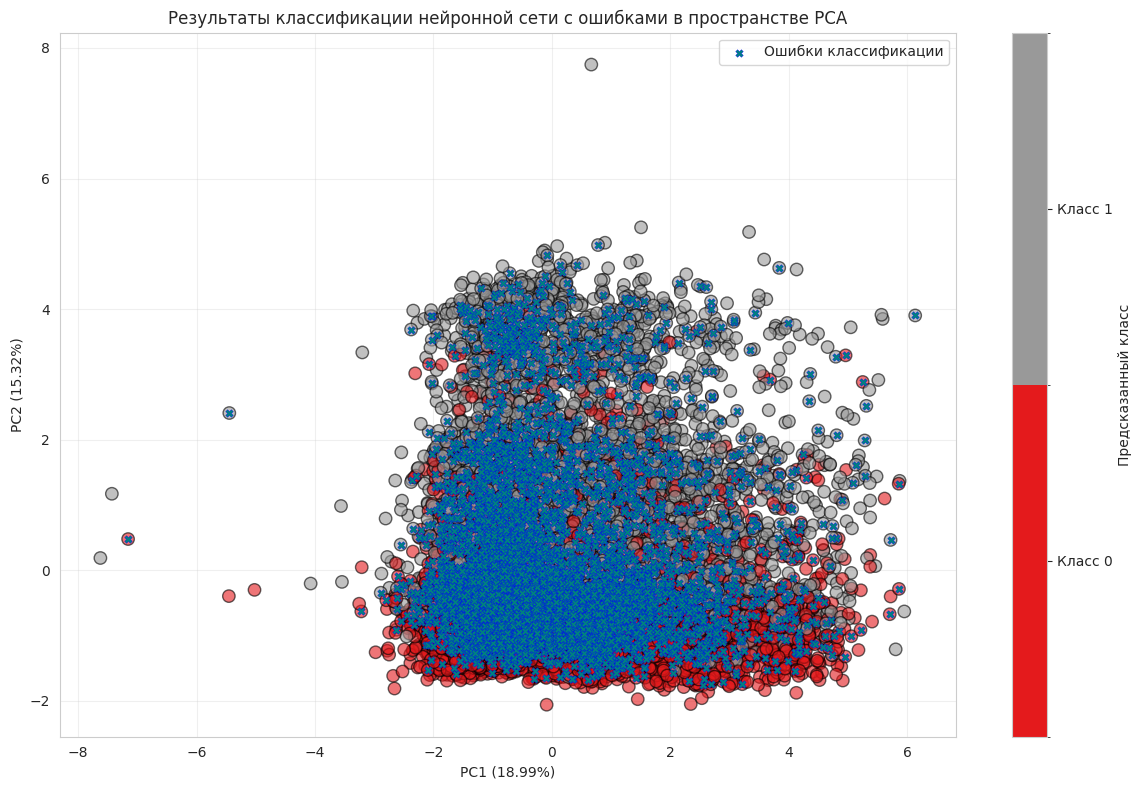


Количество ошибок: 5881 из 21000
Процент ошибок: 28.00%


In [95]:
fig, ax = plt.subplots(figsize=(12, 8))

scatter = ax.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_pred_test,
                     cmap='Set1', s=80, alpha=0.6, edgecolors='k', linewidth=1)

# Отметим неправильные предсказания символом 'X'
errors = y_pred_test != y_test
if errors.sum() > 0:
    ax.scatter(X_test_pca[errors, 0], X_test_pca[errors, 1],
               marker='X', s=30, c='teal', edgecolors='blue', linewidth=0.25,
               label='Ошибки классификации')

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
ax.set_title(
    'Результаты классификации нейронной сети с ошибками в пространстве PCA')

ax.grid(True, alpha=0.3)
cmap2 = plt.cm.get_cmap('Set1', 2)
norm = BoundaryNorm(boundaries=[-0.5, 0.5, 1.5], ncolors=2)
sm = plt.cm.ScalarMappable(cmap=cmap2, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, ticks=[0, 1], boundaries=[-0.5, 0.5, 1.5])
cbar.set_label('Предсказанный класс')
cbar.ax.set_yticklabels(['Класс 0', 'Класс 1'])

if errors.sum() > 0:
    ax.legend()
plt.tight_layout()
plt.show()

print(f"\nКоличество ошибок: {errors.sum()} из {len(y_test)}")
print(f"Процент ошибок: {errors.sum() / len(y_test) * 100:.2f}%")

## 11. Сравнение с результатами линейной дискриминантной функции Фишера (Лабораторная работа 4)

Проведем сравнение результатов нейронной сети с результатами линейной дискриминантной функции Фишера из лабораторной работы 4.

In [96]:
# Результаты нейронной сети
nn_results = {
    'Метод': 'Neural Network (Лаб. 5)',
    'Accuracy': accuracy_test,
    'Precision': precision_test,
    'Recall': recall_test,
    'F1-Score': f1_test,
    'Specificity': specificity,
    'Sensitivity': sensitivity,
    'Errors': errors.sum()
}

# Создаем таблицу сравнения
comparison_df = pd.DataFrame([fisher_results, nn_results])
comparison_df = comparison_df.set_index('Метод')

print("=" * 70)
print("СРАВНЕНИЕ РЕЗУЛЬТАТОВ")
print("=" * 70)
print("\nТаблица сравнения метрик:\n")
print(comparison_df.to_string())

# Вычисляем разницу в метриках
print("\n" + "=" * 70)
print("АНАЛИЗ РАЗЛИЧИЙ")
print("=" * 70)
diff_accuracy = (nn_results['Accuracy'] - fisher_results['Accuracy']) * 100
diff_precision = (nn_results['Precision'] - fisher_results['Precision']) * 100
diff_recall = (nn_results['Recall'] - fisher_results['Recall']) * 100
diff_f1 = (nn_results['F1-Score'] - fisher_results['F1-Score']) * 100
diff_specificity = (nn_results['Specificity'] - fisher_results['Specificity']) * 100
diff_sensitivity = (nn_results['Sensitivity'] - fisher_results['Sensitivity']) * 100
diff_errors = nn_results['Errors'] - fisher_results['Errors']

print(f"\nРазница в метриках (Нейронная сеть - Fisher LDA):")
print(f"  Accuracy:  {diff_accuracy:+.2f}%")
print(f"  Precision: {diff_precision:+.2f}%")
print(f"  Recall:    {diff_recall:+.2f}%")
print(f"  F1-Score:  {diff_f1:+.2f}%")
print(f"  Specificity:  {diff_specificity:+.2f}%")
print(f"  Sensitivity:  {diff_sensitivity:+.2f}%")
print(
    f"  Ошибки:    {diff_errors:+d} ({diff_errors/fisher_results['Errors']*100:+.1f}%)")

# Определяем лучший метод
if nn_results['Accuracy'] > fisher_results['Accuracy']:
    winner = "Нейронная сеть показывает лучшие результаты"
elif nn_results['Accuracy'] < fisher_results['Accuracy']:
    winner = "Fisher LDA показывает лучшие результаты"
else:
    winner = "Оба метода показывают одинаковые результаты"

print(f"\n{winner}")

СРАВНЕНИЕ РЕЗУЛЬТАТОВ

Таблица сравнения метрик:

                         Accuracy  Precision    Recall  F1-Score  Specificity  Sensitivity  Errors                   ErrorMatrix
Метод                                                                                                                           
Fisher LDA (Лаб. 4)      0.640952   0.651518  0.605203  0.627507     0.676661     0.605203    7540  [[7109, 3397], [4143, 6351]]
Neural Network (Лаб. 5)  0.719952   0.734520  0.688393  0.710709     0.751475     0.688393    5881                           NaN

АНАЛИЗ РАЗЛИЧИЙ

Разница в метриках (Нейронная сеть - Fisher LDA):
  Accuracy:  +7.90%
  Precision: +8.30%
  Recall:    +8.32%
  F1-Score:  +8.32%
  Specificity:  +7.48%
  Sensitivity:  +8.32%
  Ошибки:    -1659 (-22.0%)

Нейронная сеть показывает лучшие результаты


## 12. Визуальное сравнение метрик

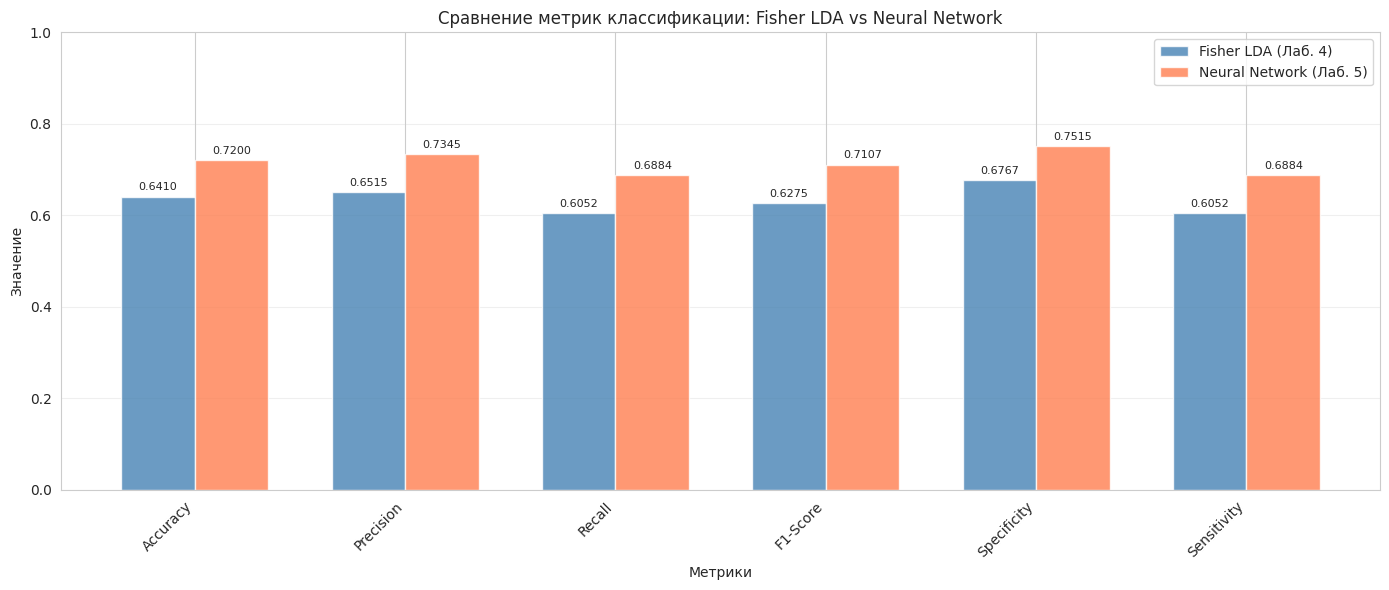

In [97]:
# Визуальное сравнение метрик
metrics = ['Accuracy', 'Precision', 'Recall',
           'F1-Score', 'Specificity', 'Sensitivity']
fisher_values = [fisher_results[m] for m in metrics]
nn_values = [nn_results[m] for m in metrics]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(14, 6))
bars1 = ax.bar(x - width/2, fisher_values, width, label='Fisher LDA (Лаб. 4)',
               color='steelblue', alpha=0.8)
bars2 = ax.bar(x + width/2, nn_values, width, label='Neural Network (Лаб. 5)',
               color='coral', alpha=0.8)

ax.set_xlabel('Метрики')
ax.set_ylabel('Значение')
ax.set_title('Сравнение метрик классификации: Fisher LDA vs Neural Network')
ax.set_xticks(x)
ax.set_xticklabels(metrics, rotation=45, ha='right')
ax.legend()
ax.set_ylim([0.0, 1.0])
ax.grid(True, alpha=0.3, axis='y')

# Добавляем значения на столбцы
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=8)

plt.tight_layout()
plt.show()

## 13. Сравнение матриц ошибок

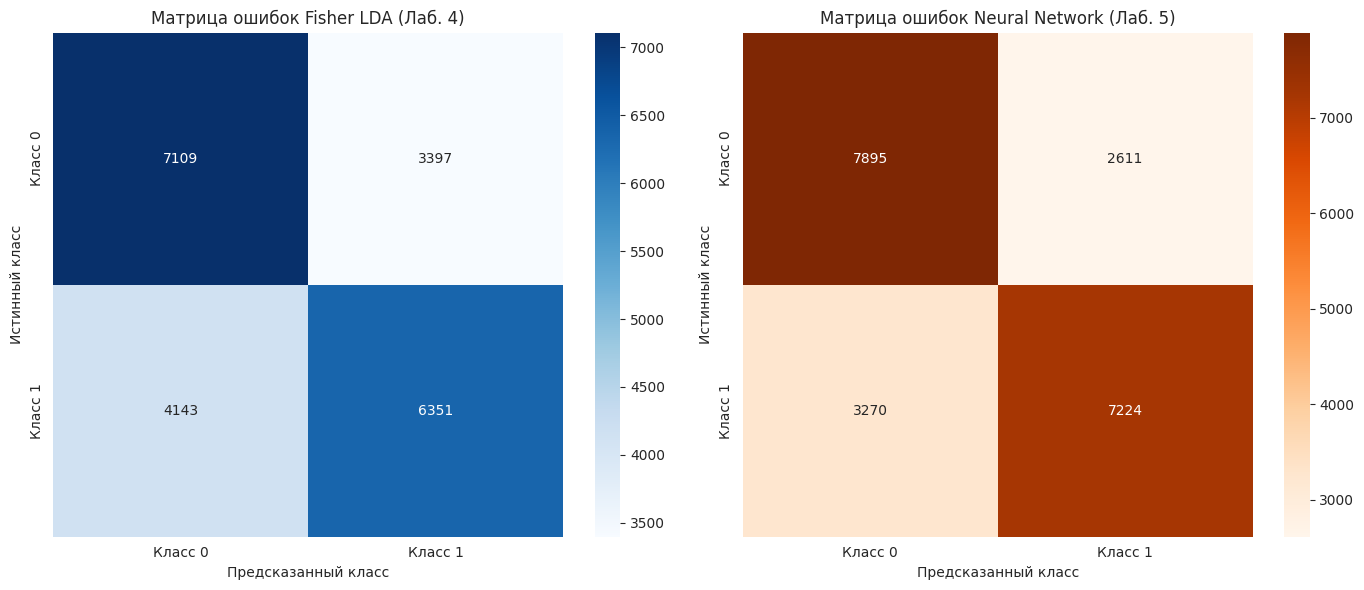


Сравнение компонентов матриц ошибок:
Компонент            Fisher LDA      Neural Network  Разница        
True Negatives       7109            7895            786            
False Positives      3397            2611            -786           
False Negatives      4143            3270            -873           
True Positives       6351            7224            873            


In [98]:
# Матрица ошибок из лабораторной работы 4
cm_fisher = fisher_results['ErrorMatrix']

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Fisher LDA
sns.heatmap(cm_fisher, annot=True, fmt='d', cmap='Blues', cbar=True, ax=axes[0],
            xticklabels=['Класс 0', 'Класс 1'],
            yticklabels=['Класс 0', 'Класс 1'])
axes[0].set_xlabel('Предсказанный класс')
axes[0].set_ylabel('Истинный класс')
axes[0].set_title('Матрица ошибок Fisher LDA (Лаб. 4)')

# Neural Network
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Oranges', cbar=True, ax=axes[1],
            xticklabels=['Класс 0', 'Класс 1'],
            yticklabels=['Класс 0', 'Класс 1'])
axes[1].set_xlabel('Предсказанный класс')
axes[1].set_ylabel('Истинный класс')
axes[1].set_title('Матрица ошибок Neural Network (Лаб. 5)')

plt.tight_layout()
plt.show()

# Сравнение компонентов матриц ошибок
print("\nСравнение компонентов матриц ошибок:")
print("=" * 70)
print(f"{'Компонент':<20} {'Fisher LDA':<15} {'Neural Network':<15} {'Разница':<15}")
print("=" * 70)
print(
    f"{'True Negatives':<20} {cm_fisher[0, 0]:<15} {cm_test[0, 0]:<15} {cm_test[0, 0]-cm_fisher[0, 0]:<15}")
print(
    f"{'False Positives':<20} {cm_fisher[0, 1]:<15} {cm_test[0, 1]:<15} {cm_test[0, 1]-cm_fisher[0, 1]:<15}")
print(
    f"{'False Negatives':<20} {cm_fisher[1, 0]:<15} {cm_test[1, 0]:<15} {cm_test[1, 0]-cm_fisher[1, 0]:<15}")
print(
    f"{'True Positives':<20} {cm_fisher[1, 1]:<15} {cm_test[1, 1]:<15} {cm_test[1, 1]-cm_fisher[1, 1]:<15}")
print("=" * 70)

# Общий вывод по работе

## Содержание работы

В ходе данной работы была реализована **двухслойная нейронная сеть** для бинарной классификации данных датасета `maleorfemale.csv`. Использовалась разметка по столбцу пола из исходных данных.

## Архитектура нейронной сети

Построенная нейронная сеть имеет следующую архитектуру:

1. **Входной слой**: размерность соответствует количеству признаков (11 признаков)
2. **Скрытый слой**: 33 нейрона, функция активации ReLU
3. **Выходной слой**: 1 нейрон, функция активации Sigmoid
4. **Функция потерь**: Binary Cross-Entropy
5. **Оптимизатор**: Градиентный спуск с momentum (коэффициент 0.9)
6. **Скорость обучения**: 0.05
7. **Количество эпох**: 500
8. **Размер батча**: 256 (оптимизирован для эффективного использования многопоточности NumPy)

Сеть была реализована **без использования специальных библиотек** (TensorFlow, PyTorch) с полной реализацией:
- Прямого распространения (forward propagation)
- Обратного распространения ошибки (backpropagation)
- Градиентного спуска с momentum
- Функций активации (ReLU, Sigmoid)
- Функции потерь (Binary Cross-Entropy)
- Параллельной обработки батчей с использованием всех доступных CPU

Дополнительно была реализована модель на Keras с идентичной архитектурой для валидации корректности собственной реализации.

## Результаты классификации нейронной сети

Реализация продемонстрировала следующие результаты после 500 эпох обучения:

- **Точность (Accuracy)**: 71.99% на тестовой выборке
- **Полнота (Recall)**: 68.83% для класса 1
- **Точность предсказаний (Precision)**: 73.45% для класса 1
- **F1-Score**: 0.7107

Разница между собственной реализацией и Keras составляет менее 1% по всем метрикам, что подтверждает корректность реализации алгоритма обратного распространения ошибки и градиентного спуска.

## Сравнение с линейной дискриминантной функцией Фишера (Лабораторная работа 4)

| Метрика      | Fisher LDA (Лаб. 4) | Neural Network (Лаб. 5) | Разница |
|--------------|---------------------|-------------------------|---------|
| Accuracy     | 0.640952            | 0.719952                | +7.90%  |
| Precision    | 0.651518            | 0.734520                | +8.30%  |
| Recall       | 0.605203            | 0.688393                | +8.32%  |
| F1-Score     | 0.627507            | 0.710709                | +8.32%  |
| Specificity  | 0.676661            | 0.751475                | +7.48%  |
| Sensitivity  | 0.605203            | 0.688393                | +8.32%  |

### Основные выводы из сравнения:

1. **Нейронная сеть показала лучшие результаты**: Точность классификации NN (71.9952%) превышает точность Fisher LDA (64.0952%)

## Анализ результатов

### Почему нейронная сеть показала лучшие результаты?

1. Способность к нелинейному преобразованию признаков: Несмотря на кажущуюся линейную разделимость данных, нейронная сеть с функцией активации ReLU смогла найти более оптимальное представление признаков в скрытом слое, что привело к лучшему разделению классов.

2. Оптимизация на большом количестве эпох: 500 эпох обучения с градиентным спуском и momentum позволили модели тщательно настроить веса для минимизации ошибок.

3. Адаптивность архитектуры: 33 нейрона в скрытом слое предоставили достаточную выразительную мощность для изучения сложных взаимосвязей между 11 признаками.

4. Общее снижение ошибок.

### Преимущества и недостатки методов

**Fisher LDA (Лаб. 4)**:

Плюсы:
- Простота реализации и интерпретации
- Быстрое обучение (аналитическое решение)
- Не требует подбора параметров
- Меньше вычислительных затрат

Минусы:
- Ограничен линейными границами решений
- Не масштабируется на сложные задачи

**Neural Network (Лаб. 5)**:

Плюсы:
- Универсальность (может решать нелинейные задачи)
- Масштабируемость (можно добавлять слои)
- Способность к обучению сложным паттернам
- Требует подбора параметров

Минусы:
- Более сложная реализация
- Требует больше вычислительных ресурсов
- Менее интерпретируема

## Итоговые выводы

1. Нейронная сеть превзошла линейный классификатор: На данном датасете двухслойная нейронная сеть показала лучшие результаты, опровергнув предположение о полной линейной разделимости данных.

2. Практическое преимущество нейронных сетей: Уменьшение количества ошибок демонстрирует, что даже простая двухслойная архитектура может существенно превосходить классические линейные методы.

3. Потенциал для улучшения: Несмотря на отличные результаты, возможно дальнейшее улучшение через:
   - Подбор оптимальных гиперпараметров (размер скрытого слоя, learning rate)
   - Использование более сложных архитектур